# Sparkify Project

In this project user churn rate is predicted for a music streaming software called Sparkify.

### Notebook Content
**1. Get started**
- Import packages
- Build spark session

**2. Extract data**
- Extract data from local .json or a s3 storage

**3. Clean data**
- Drop null values
- Add column indicating churn (label)
- Aggregate data on user level
- Calculate several aggregates per user, such as session count or user age
- Ensure numeric value

**4. Exploratory Data Analysis**
- Show aggregates of each column

**5. Feature Engineering**
- One Hot Encoding for categorical features
- Assembling feature vector

**6. Modeling**
- Build pipeline (random forest + logistic regression)
- Find best model with grid search
- Evaluate accuracy and F2

## 1. Get Started
Import required packages for [pyspark sql](https://spark.apache.org/docs/2.2.0/api/python/pyspark.sql.html) and [mlib](https://spark.apache.org/docs/2.2.0/api/python/pyspark.ml.html).

In [1]:
# SQL
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, from_unixtime, trunc, isnan, when, count, col, lit, countDistinct, lag, isnull
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col
from pyspark.sql import functions as f
from pyspark.sql import types as t

# MLib
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler

# Other
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

sparkContext = spark.sparkContext

## 2. Extract Data
Extract data from a local file or access Amazon S3.

In [3]:
# For running on a EC2 cluster 
event_data_s3n_small = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
event_data_s3n_full = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"

# For local use
event_data_local = "data/mini_sparkify_event_data.json"

df = spark.read.json(event_data_local)
df.head(2)

# User very small subset of data for trying out functions
#df = df.limit(1000)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

## 2. Clean Data
Check for empty values and null values. 
Create dataframe that aggregates data on a user level.

### Checking for null, empty and other faulty values

In [4]:
# Show how many null values each column has
for column in df.columns:
    print("Column " + column + " has " + str(len(df.where(df[column] == "").collect())) + " empty values.")

Column artist has 0 empty values.
Column auth has 0 empty values.
Column firstName has 0 empty values.
Column gender has 0 empty values.
Column itemInSession has 0 empty values.
Column lastName has 0 empty values.
Column length has 0 empty values.
Column level has 0 empty values.
Column location has 0 empty values.
Column method has 0 empty values.
Column page has 0 empty values.
Column registration has 0 empty values.
Column sessionId has 0 empty values.
Column song has 0 empty values.
Column status has 0 empty values.
Column ts has 0 empty values.
Column userAgent has 0 empty values.
Column userId has 8346 empty values.


In [5]:
print("Remove rows with empty userIds.")
df = df.where(df.userId != "")
print("Check how many empty userIds are left: " + \
      str(len(df.where(df.userId == "").collect())))

Remove rows with empty userIds.
Check how many empty userIds are left: 0


In [6]:
print("Null values per column:")
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show(vertical=True)

Null values per column:
-RECORD 0------------
 artist        | 0   
 auth          | 0   
 firstName     | 0   
 gender        | 0   
 itemInSession | 0   
 lastName      | 0   
 length        | 0   
 level         | 0   
 location      | 0   
 method        | 0   
 page          | 0   
 registration  | 0   
 sessionId     | 0   
 song          | 0   
 status        | 0   
 ts            | 0   
 userAgent     | 0   
 userId        | 0   



In [7]:
print("Example event flow for one particular user:")
df.where(df.userId == 100001).select("page", "ts").orderBy("ts").show(1000)

Example event flow for one particular user:
+--------------------+-------------+
|                page|           ts|
+--------------------+-------------+
|                Home|1538376504000|
|            NextSong|1538376509000|
|         Roll Advert|1538376542000|
|            NextSong|1538376747000|
|         Roll Advert|1538376783000|
|            NextSong|1538377349000|
|            NextSong|1538377748000|
|            NextSong|1538377932000|
|            NextSong|1538378245000|
|            NextSong|1538378483000|
|            NextSong|1538378687000|
|            NextSong|1538378877000|
|            NextSong|1538379041000|
|            NextSong|1538379207000|
|         Roll Advert|1538379230000|
|            NextSong|1538379420000|
|            NextSong|1538379668000|
|            NextSong|1538380000000|
|            NextSong|1538380179000|
|              Logout|1538380180000|
|                Home|1538380429000|
|            NextSong|1538380481000|
|            NextSong|153838082

#### Get users that churned
Creating a column `Churn` to use as the label for your model. I am using the `Cancellation Confirmation` events to define churn, which happen for both paid and free users.

In [8]:
# Get users that churned
churned_users = df.where(df.page == "Cancellation Confirmation").select("userId").dropDuplicates()

#### Add a boolean column to df indicating user churn

In [9]:
churn = udf(lambda x: 1, IntegerType())
churned_users = churned_users.withColumn("churned", lit(1))
churned_users.show(5)

# Join new column to df
df = df.join(churned_users, on=['userId'], how='left')

+------+-------+
|userId|churned|
+------+-------+
|   125|      1|
|    51|      1|
|    54|      1|
|100014|      1|
|   101|      1|
+------+-------+
only showing top 5 rows



### Calculate aggregates per user that are interesting

#### Create dataframe that is aggregated on user level

In [10]:
# Create user aggregation and add churn information
df_user_agg = df.select(["userId", "gender", "churned"]).groupBy(["userId", "gender"]).max()
df_user_agg = df_user_agg.na.fill(0)
df_user_agg = df_user_agg.withColumnRenamed("max(churned)", "churned")

In [11]:
df_user_agg.show(5)

+------+------+-------+
|userId|gender|churned|
+------+------+-------+
|100010|     F|      0|
|200002|     M|      0|
|   125|     M|      1|
|   124|     F|      0|
|    51|     M|      1|
+------+------+-------+
only showing top 5 rows



In [12]:
print("Columns in df:")
print(df.columns)
print("\nEvent types:")
df.select("page").dropDuplicates().orderBy(df.page.asc()).show()

Columns in df:
['userId', 'artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'churned']

Event types:
+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [13]:
# Calculate songs per user
df_songs_per_user = df.where(df.page == "NextSong").select(["userId", "page"]).groupBy(["userId"]).count()
df_songs_per_user = df_songs_per_user.withColumnRenamed("count", "songs_listened")

In [14]:
# Calculate ads per user
df_ads_per_user = df.where(df.page == "Roll Advert").select(["userId", "page"]).groupBy(["userId"]).count()
df_ads_per_user = df_ads_per_user.withColumnRenamed("count", "adverts_rolled")

In [15]:
# Calculate friends added per user
df_friends_added_per_user = df.where(df.page == "Add Friend").select(["userId", "page"]).groupBy(["userId"]).count()
df_friends_added_per_user = df_friends_added_per_user.withColumnRenamed("count", "friends_added")

In [16]:
# Calculate upgrades to premium per user
df_upgrades_per_user = df.where(df.page == "Submit Upgrade").select(["userId", "page"]).groupBy(["userId"]).count()
df_upgrades_per_user = df_upgrades_per_user.withColumnRenamed("count", "times_upgraded")

In [17]:
# Calculate downgrades for free per user
df_downgrades_per_user = df.where(df.page == "Submit Downgrade").select(["userId", "page"]).groupBy(["userId"]).count()
df_downgrades_per_user = df_downgrades_per_user.withColumnRenamed("count", "times_downgraded")

In [18]:
# Calculate playlist additions per user
df_playlist_adds_per_user = df.where(df.page == "Add to Playlist").select(["userId", "page"]).groupBy(["userId"]).count()
df_playlist_adds_per_user = df_playlist_adds_per_user.withColumnRenamed("count", "playlist_additions")

In [19]:
# Calculate errors per user
df_errors_per_user = df.where(df.page == "Error").select(["userId", "page"]).groupBy(["userId"]).count()
df_errors_per_user = df_errors_per_user.withColumnRenamed("count", "errors")

In [20]:
# Calculate help access per user
df_help_per_user = df.where(df.page == "Help").select(["userId", "page"]).groupBy(["userId"]).count()
df_help_per_user = df_help_per_user.withColumnRenamed("count", "help_access_count")

In [21]:
# Calculate logouts per user
df_logouts_per_user = df.where(df.page == "Logout").select(["userId", "page"]).groupBy(["userId"]).count()
df_logouts_per_user = df_logouts_per_user.withColumnRenamed("count", "logouts")

In [22]:
# Calculate thumbs up per user
df_thumbs_up_per_user = df.where(df.page == "Thumbs Up").select(["userId", "page"]).groupBy(["userId"]).count()
df_thumbs_up_per_user = df_thumbs_up_per_user.withColumnRenamed("count", "thumbs_up_given")

In [23]:
# Calculate thumbs down per user
df_thumbs_down_per_user = df.where(df.page == "Thumbs Down").select(["userId", "page"]).groupBy(["userId"]).count()
df_thumbs_down_per_user = df_thumbs_down_per_user.withColumnRenamed("count", "thumbs_down_given")

In [24]:
# Calculate time registered ("user age")
df_age_per_user = df.groupBy("userId").agg(f.max('ts').alias("last_login"), \
    f.min('registration').alias("registration"))

df_age_per_user = df_age_per_user.withColumn("user_age", df_age_per_user.last_login - df_age_per_user.registration)

df_age_per_user.show(1)

+------+-------------+-------------+----------+
|userId|   last_login| registration|  user_age|
+------+-------------+-------------+----------+
|100010|1542823952000|1538016340000|4807612000|
+------+-------------+-------------+----------+
only showing top 1 row



#### Number of sessions
The number of sessions is calculated by calculating the **distinct count of session IDs per user**. 
- It appears the session ID itself does not represent the number of sesssion of that user, as they usually don't follow the numerical series 1..n but are fragmentary. Therefore I can not use the **max sessionId per user** as session count. 
- The last event of each session is not necessarily a "logout" and the first event is not always the "Home" page, but they can happen within one session Id. This means I also can't use the **number of "Home" pages per user** as session count.

In [25]:
print("Illustrates the points mentioned in the markdown above.")
df.where(df.userId == 200002).select("sessionId", "page").orderBy("ts").show(1000)

Illustrates the points mentioned in the markdown above.
+---------+---------------+
|sessionId|           page|
+---------+---------------+
|        2|       NextSong|
|        2|    Roll Advert|
|        2|       NextSong|
|        2|       NextSong|
|        2|      Thumbs Up|
|        2|       NextSong|
|        2|Add to Playlist|
|       44|       NextSong|
|       44|       NextSong|
|       44|       NextSong|
|       44|       NextSong|
|       44|    Roll Advert|
|       44|       NextSong|
|       44|       NextSong|
|       44|          About|
|       44|     Add Friend|
|       44|           Home|
|       44|       Settings|
|       44|       NextSong|
|       44|           Home|
|       44|     Add Friend|
|       44|       NextSong|
|       44|       NextSong|
|       44|       NextSong|
|       44|       NextSong|
|       44|       NextSong|
|       44|      Thumbs Up|
|       44|       NextSong|
|       44|       NextSong|
|       44|       NextSong|
|       44|       Ne

In [26]:
# Calculate number of sessions per user
df_sessions_per_user = df.select(["userId", "sessionId"]).groupBy("userId").agg(countDistinct("sessionId"))
df_sessions_per_user = df_sessions_per_user.withColumnRenamed("count(sessionId)", "session_count")

In [27]:
# Calculate session start and session end and session length
df_session_info_per_user = df.groupBy("userId", "sessionId").agg(f.min('ts').alias("session_start"), \
    f.max('ts').alias("session_end"))

df_session_info_per_user = df_session_info_per_user.withColumn("session_length", \
    df_session_info_per_user.session_end - df_session_info_per_user.session_start)


# Calculate average session length and average time between sessions
df_session_info_per_user = df_session_info_per_user.withColumn('session_end_last_session',
                        f.lag(df_session_info_per_user['session_end'], 1)
                                 .over(Window.partitionBy("userId").orderBy("userId")))

df_session_info_per_user = df_session_info_per_user.withColumn("time_since_last_session", \
    df_session_info_per_user.session_start - df_session_info_per_user.session_end_last_session)

df_session_info_per_user.show()

+------+---------+-------------+-------------+--------------+------------------------+-----------------------+
|userId|sessionId|session_start|  session_end|session_length|session_end_last_session|time_since_last_session|
+------+---------+-------------+-------------+--------------+------------------------+-----------------------+
|100010|       31|1539003534000|1539010247000|       6713000|                    null|                   null|
|100010|       78|1539603322000|1539604675000|       1353000|           1539010247000|              593075000|
|100010|      113|1539699018000|1539707924000|       8906000|           1539604675000|               94343000|
|100010|      118|1540045112000|1540055028000|       9916000|           1539707924000|              337188000|
|100010|      133|1541411290000|1541424085000|      12795000|           1540055028000|             1356262000|
|100010|      174|1541731560000|1541750940000|      19380000|           1541424085000|              307475000|
|

In [28]:
df_session_info_per_user = df_session_info_per_user.groupBy("userId").agg(f.mean('session_length'), f.mean('time_since_last_session'))
df_session_info_per_user = df_session_info_per_user.withColumnRenamed("avg(session_length)", "avg_session_length")
df_session_info_per_user = df_session_info_per_user.withColumnRenamed("avg(time_since_last_session)", "avg_time_between_sessions")

df_session_info_per_user.show()

+------+--------------------+-------------------------+
|userId|  avg_session_length|avg_time_between_sessions|
+------+--------------------+-------------------------+
|100010|           9269000.0|               6.259225E8|
|200002|            1.5984E7|                7.67004E8|
|   125|           1774000.0|                     null|
|   124|3.4739655172413796E7|     1.4915307142857143E8|
|    51|           5.23414E7|       9.33251111111111E7|
|     7|   5258428.571428572|               7.251555E8|
|    15|            3.1697E7|     3.0406771428571427E8|
|    54| 1.933737837837838E7|               8.283875E7|
|   155|3.2914333333333332E7|               4.068078E8|
|100014|1.1088833333333334E7|                6.99396E8|
|   132|        2.99370625E7|               2.589322E8|
|   154|           6641000.0|              1.0694535E9|
|   101|           4.90548E7|       9.77648888888889E7|
|    11|           9682625.0|               2.963434E8|
|   138|           3.38536E7|      3.09801928571

In [29]:
print("How often is average time between sessions NULL due to user having only one session?")
df_session_info_per_user.select([count(when(isnull(c), c)).alias(c) for c in df_session_info_per_user.columns]).show()

How often is average time between sessions NULL due to user having only one session?
+------+------------------+-------------------------+
|userId|avg_session_length|avg_time_between_sessions|
+------+------------------+-------------------------+
|     0|                 0|                       15|
+------+------------------+-------------------------+



After the join the NULL values will become 0.

In [30]:
# Join aggregates together to one table
df_user_agg = df_user_agg.join(df_songs_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_ads_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_friends_added_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_playlist_adds_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_errors_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_help_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_logouts_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_thumbs_up_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_thumbs_down_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_upgrades_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_downgrades_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_age_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_sessions_per_user, on=['userId'], how='left')
df_user_agg = df_user_agg.join(df_session_info_per_user, on=['userId'], how='left')

# Fill null values created after join with 0, as they represent missing counts
df_user_agg = df_user_agg.na.fill(0)

In [31]:
df_user_agg.where(df_user_agg.userId == 125).show(1, vertical=True)

-RECORD 0----------------------------------
 userId                    | 125           
 gender                    | M             
 churned                   | 1             
 songs_listened            | 8             
 adverts_rolled            | 1             
 friends_added             | 0             
 playlist_additions        | 0             
 errors                    | 0             
 help_access_count         | 0             
 logouts                   | 0             
 thumbs_up_given           | 0             
 thumbs_down_given         | 0             
 times_upgraded            | 0             
 times_downgraded          | 0             
 last_login                | 1539318918000 
 registration              | 1533157139000 
 user_age                  | 6161779000    
 session_count             | 1             
 avg_session_length        | 1774000.0     
 avg_time_between_sessions | 0.0           



## 3. Explore Data


In [32]:
print('Number of distinct users:')
print(len(df.dropDuplicates(['userId']).collect()))
print("\nNumber of churned users:")
print(len(churned_users.collect()))

Number of distinct users:
225

Number of churned users:
52


#### Observe different aggregates

In [33]:
df_user_agg.groupBy("churned").agg(f.mean('songs_listened'), \
    f.mean('adverts_rolled'), \
    f.mean('friends_added'), \
    f.mean('playlist_additions'), \
    f.mean('errors')).show()

+-------+-------------------+-------------------+------------------+-----------------------+------------------+
|churned|avg(songs_listened)|avg(adverts_rolled)|avg(friends_added)|avg(playlist_additions)|       avg(errors)|
+-------+-------------------+-------------------+------------------+-----------------------+------------------+
|      1|  699.8846153846154| 18.596153846153847| 12.23076923076923|      19.96153846153846|0.6153846153846154|
|      0| 1108.1734104046243|  17.14450867052023|21.046242774566473|     31.722543352601157|1.2716763005780347|
+-------+-------------------+-------------------+------------------+-----------------------+------------------+



In [34]:
df_user_agg.groupBy("churned").agg(f.mean('thumbs_up_given'), \
    f.mean('thumbs_down_given'), \
    f.mean('times_upgraded'), \
    f.mean('times_downgraded'), \
    f.mean('logouts'), \
    f.mean('help_access_count')).show()

+-------+--------------------+----------------------+-------------------+---------------------+------------------+----------------------+
|churned|avg(thumbs_up_given)|avg(thumbs_down_given)|avg(times_upgraded)|avg(times_downgraded)|      avg(logouts)|avg(help_access_count)|
+-------+--------------------+----------------------+-------------------+---------------------+------------------+----------------------+
|      1|               35.75|     9.538461538461538| 0.6153846153846154|  0.17307692307692307|10.634615384615385|     4.596153846153846|
|      0|   61.80346820809248|     11.84971098265896| 0.7341040462427746|  0.31213872832369943| 15.45086705202312|     7.023121387283237|
+-------+--------------------+----------------------+-------------------+---------------------+------------------+----------------------+



In [35]:
df_user_agg.groupBy("churned").agg(f.mean('avg_session_length'), \
    f.mean('session_count'), \
    f.mean('avg_time_between_sessions')).show()

+-------+-----------------------+------------------+------------------------------+
|churned|avg(avg_session_length)|avg(session_count)|avg(avg_time_between_sessions)|
+-------+-----------------------+------------------+------------------------------+
|      1|    1.557447181734887E7|10.326923076923077|          2.2533990694536653E8|
|      0|   1.7805596823630523E7|15.254335260115607|          5.0146069952643836E8|
+-------+-----------------------+------------------+------------------------------+



In [36]:
# Convert from unix time to normal time to see results in human readable way
df_user_agg.groupBy("churned").agg(\
    from_unixtime(f.mean('last_login') / 1000 ,"yyyy-MM-dd HH:mm:ss:SSS").alias("avg_last_login"),
    from_unixtime(f.mean('registration') / 1000 ,"yyyy-MM-dd HH:mm:ss:SSS").alias("avg_registration"), \
    (f.mean('user_age') / 1000/3600/24).alias("avg_user_age_days")).show()

+-------+--------------------+--------------------+------------------+
|churned|      avg_last_login|    avg_registration| avg_user_age_days|
+-------+--------------------+--------------------+------------------+
|      1|2018-10-27 14:03:...|2018-08-31 06:42:...|57.305992922008535|
|      0|2018-11-24 12:26:...|2018-08-29 22:32:...| 86.62061938021837|
+-------+--------------------+--------------------+------------------+



# Feature Engineering
One Hot Encoding categorical columns (gender) and assembling required subset of features into a feature vector.
The output feature column is not scaled yet and therefore called "features_raw".

#### Select required features

In [37]:
# Select required features
feature_list = ["genderIndex", "songs_listened", "adverts_rolled", "friends_added", "playlist_additions",\
               "errors", "help_access_count", "logouts", "thumbs_up_given", "thumbs_down_given",\
              "times_upgraded", "times_downgraded", "user_age", "session_count", "avg_session_length", "avg_time_between_sessions"]

#### One Hot Encoding the Gender Column

In [38]:
# Use OneHotEncoding to transform gender into one hot vector 
stringIndexer = StringIndexer(inputCol="gender", outputCol="genderIndex")
model = stringIndexer.fit(df_user_agg)
indexed = model.transform(df_user_agg)

# In Cloud
#encoder = OneHotEncoder(inputCol="genderIndex", outputCol="genderIndexVec")
#df_features = encoder.transform(indexed)

# Local
encoder = OneHotEncoder(inputCol="genderIndex", outputCol="genderIndexVec")
encoder.setDropLast(False)
ohe = encoder.fit(indexed)
df_features = ohe.transform(indexed)

In [39]:
# https://stackoverflow.com/questions/49632830/pyspark-output-of-onehotencoder-looks-odd
df_features.select("gender", "genderIndex", "genderIndexVec").show(5)

+------+-----------+--------------+
|gender|genderIndex|genderIndexVec|
+------+-----------+--------------+
|     F|        1.0| (2,[1],[1.0])|
|     M|        0.0| (2,[0],[1.0])|
|     M|        0.0| (2,[0],[1.0])|
|     F|        1.0| (2,[1],[1.0])|
|     M|        0.0| (2,[0],[1.0])|
+------+-----------+--------------+
only showing top 5 rows



#### Feature Vector Assembler

In [40]:
# Assemble columns into feature vector
assembler = VectorAssembler(
    inputCols=feature_list,
    outputCol="features_raw")

output = assembler.transform(df_features)

feature_str = ""
for feature in feature_list:
    feature_str = feature_str + feature + ", "
    
print("Assembled columns " + feature_str + " to vector column 'features'")

# Rename churned column to label
output = output.withColumnRenamed("churned", "label")
df_features = output.select("features_raw", "label")
df_features.show(truncate=False)

Assembled columns genderIndex, songs_listened, adverts_rolled, friends_added, playlist_additions, errors, help_access_count, logouts, thumbs_up_given, thumbs_down_given, times_upgraded, times_downgraded, user_age, session_count, avg_session_length, avg_time_between_sessions,  to vector column 'features'
+------------------------------------------------------------------------------------------------------------------------+-----+
|features_raw                                                                                                            |label|
+------------------------------------------------------------------------------------------------------------------------+-----+
|[1.0,275.0,52.0,4.0,7.0,0.0,2.0,5.0,17.0,5.0,0.0,0.0,4.807612E9,7.0,9269000.0,6.259225E8]                               |0    |
|[0.0,387.0,7.0,4.0,8.0,0.0,2.0,5.0,21.0,6.0,1.0,0.0,6.054448E9,6.0,1.5984E7,7.67004E8]                                  |0    |
|(16,[1,2,12,13,14],[8.0,1.0,6.161779E9,1.0,177400

## Modeling
Split the full dataset into train, test, and validation sets. 
Test out two ML models:
- Random Forest Classifier
- Logistic Regression

Evaluating the accuracy of the various models, tuning parameters as necessary.

In [41]:
train, test = df_features.select(["features_raw", "label"]).randomSplit([0.7, 0.3], seed=42)

#### Apply Standard Scaler to Feature Vector (only use training data for fittting)

In [42]:
scaler = StandardScaler(inputCol="features_raw", outputCol="features",
                        withStd=True, withMean=True)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(train)

# Normalize each feature to have unit standard deviation.
train = scalerModel.transform(train)
test = scalerModel.transform(test)

# Select only relevant columns
train = train.select("features", "label")
test = test.select("features", "label")

# Show example train and test data
train.show(1, vertical=True, truncate=False)
test.show(1, vertical=True, truncate=False)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 features | [-0.9325754498682505,-0.5526600809578356,-0.49231754797110855,-0.6964433322333075,-0.6235203295676267,-0.7915676095445291,-0.6022091483855642,-0.5884711680395417,-0.5244620323432457,-0.39256089653906656,0.34799816664863403,-0.48950888391319386,-0.26698516950941126,-0.5467538734320886,-0.09850232780451082,0.8377400629808378] 
 label    | 0                                                                                                                                                                                                                                                                                                                     

## Model 1 - Random Forest

In [43]:
# Configure Random Forest classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[rf])

In [44]:
model_name = "Random Forest"

### Tune Model

In [45]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees,[4, 8, 12]) \
    .addGrid(rf.maxDepth,[5, 10, 20, 30]) \
    .addGrid(rf.maxBins,[100, 200]) \
    .build()



crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)

In [46]:
cvModel_q1 = crossval.fit(train)

In [47]:
cvModel_q1.avgMetrics

[0.6465045188729399,
 0.6465045188729399,
 0.649380648591175,
 0.649380648591175,
 0.649380648591175,
 0.649380648591175,
 0.649380648591175,
 0.649380648591175,
 0.7633187134502923,
 0.7633187134502923,
 0.7512858851674641,
 0.7512858851674641,
 0.7512858851674641,
 0.7512858851674641,
 0.7512858851674641,
 0.7512858851674641,
 0.694493620414673,
 0.694493620414673,
 0.6832329877724614,
 0.6832329877724614,
 0.6832329877724614,
 0.6832329877724614,
 0.6832329877724614,
 0.6832329877724614]

In [48]:
results = cvModel_q1.transform(test)

In [49]:
results.show(2)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-0.9325754498682...|    1|           [5.0,3.0]|       [0.625,0.375]|       0.0|
|[-0.9325754498682...|    0|[7.52851390755823...|[0.94106423844477...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



In [50]:
# Get best pipeline and params
bestPipeline = cvModel_q1.bestModel
bestRFModel = bestPipeline.stages[-1]

maxBins_best = bestRFModel._java_obj.getMaxBins()
maxDepth_best = bestRFModel._java_obj.getMaxDepth()
numTrees_best = bestRFModel._java_obj.getNumTrees()

print("The best performing params: \n" + \
     "numTrees: " + str(numTrees_best) + "\n" + \
     "maxDepth: " + str(maxDepth_best) + "\n" + \
     "maxBins: " + str(maxBins_best) + "."
)

The best performing params: 
numTrees: 8
maxDepth: 5
maxBins: 100.


#### Get most influential features

In [51]:
# Get coefficients
coefficients = bestRFModel.featureImportances.toArray()
coefficients = pd.DataFrame(data=[coefficients])
coefficients.columns = feature_list
coefficients = coefficients.sort_values(by=0 , ascending=False, axis=1).round(2)

# Transpose for better visualization
coefficients_transposed = coefficients.transpose()
coefficients_transposed.columns = ['coefficient']
coefficients_transposed

,coefficient
user_age,0.30
avg_time_between_sessions,0.14
session_count,0.09
thumbs_up_given,0.08
songs_listened,0.07
logouts,0.06
thumbs_down_given,0.06
adverts_rolled,0.05
playlist_additions,0.05
avg_session_length,0.04


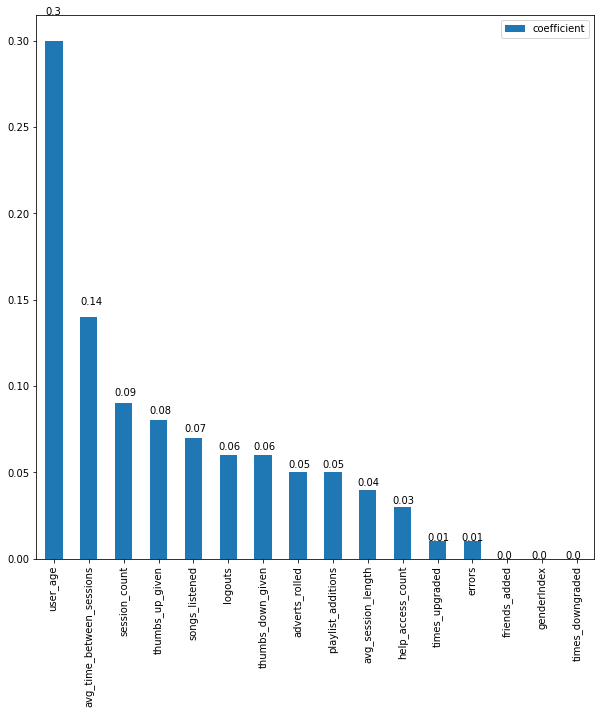

In [52]:
# Visualize
ax = coefficients_transposed.plot.bar(figsize=(10,10))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 0.995, p.get_height() * 1.05))

### Compute F1 Score

#### Model Evaluation Metrics
How well was churn predicted among churned users?

- **Precision** = True Positive / (True Positive + False Positive)
- **Recall** = True Positive / Total Actual Positive 
- **F1 Score** = 2 * ((Precision * Recall) / (Precision + Recall))

Source: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

In [53]:
# Calculate TP, FP, TN, FN
tp = results.filter((results.label == 1) & (results.prediction == 1)).count()
fp = results.filter((results.label == 0) & (results.prediction == 1)).count()
tn = results.filter((results.label == 0) & (results.prediction == 0)).count()
fn = results.filter((results.label == 1) & (results.prediction == 0)).count()
overall_users = results.count()

In [54]:
print("Overall users in test: " + str(overall_users))
print("True Positives: " + str(tp))
print("False Positives: " + str(fp))
print("True Negatives: " + str(tn))
print("False Negatives: " + str(fn))

Overall users in test: 60
True Positives: 7
False Positives: 2
True Negatives: 42
False Negatives: 9


In [55]:
precision = tp / (tp+fp)
recall = tp / (tp + fn)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Precision " + model_name + ": " + str(round(precision, 2)))
print("Recall " + model_name + ": " + str(round(recall, 2)))
print("F1 Score " + model_name + ": " + str(round(f1_score, 2)))

Precision Random Forest: 0.78
Recall Random Forest: 0.44
F1 Score Random Forest: 0.56


## Model 2 - Logistic Regression

### Build Pipeline

In [56]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline = Pipeline(stages=[lr])

In [57]:
model_name = "Logistic Regression"

### Tune Model

In [58]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .addGrid(lr.maxIter,[5, 10, 50, 100]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)

In [59]:
cvModel_q2 = crossval.fit(train)

In [60]:
cvModel_q2.avgMetrics

[0.8332296650717709,
 0.7573112706007443,
 0.6127671451355661,
 0.6075039872408292,
 0.8068527379053698,
 0.805239234449761,
 0.805239234449761,
 0.805239234449761]

In [61]:
results = cvModel_q2.transform(test)

In [62]:
results.show(2)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-0.9325754498682...|    1|[-0.4938029729807...|[0.37899809450487...|       1.0|
|[-0.9325754498682...|    0|[2.14990827487367...|[0.89566020520367...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



In [63]:
# Get best pipeline and params
bestPipeline = cvModel_q2.bestModel
bestLRModel = bestPipeline.stages[-1]

regParam_best = bestLRModel._java_obj.getRegParam()
maxIter_best = bestLRModel._java_obj.getMaxIter()

print("The best performing params: \n" + \
     "regParam: " + str(regParam_best) + "\n" + \
     "maxIter: " + str(maxIter_best)
)

The best performing params: 
regParam: 0.0
maxIter: 5


#### Get most influential features

In [64]:
# Get coefficients
coefficients = bestLRModel.coefficientMatrix.values
coefficients = pd.DataFrame(data=[coefficients])
coefficients.columns = feature_list
coefficients = coefficients.sort_values(by=0 , ascending=False, axis=1).round(2)

# Transpose for better visualization
coefficients_transposed = coefficients.transpose()
coefficients_transposed.columns = ['coefficient']
coefficients_transposed

,coefficient
thumbs_down_given,0.43
adverts_rolled,0.36
help_access_count,0.14
times_upgraded,0.12
songs_listened,-0.05
playlist_additions,-0.07
logouts,-0.08
times_downgraded,-0.13
genderIndex,-0.15
thumbs_up_given,-0.15


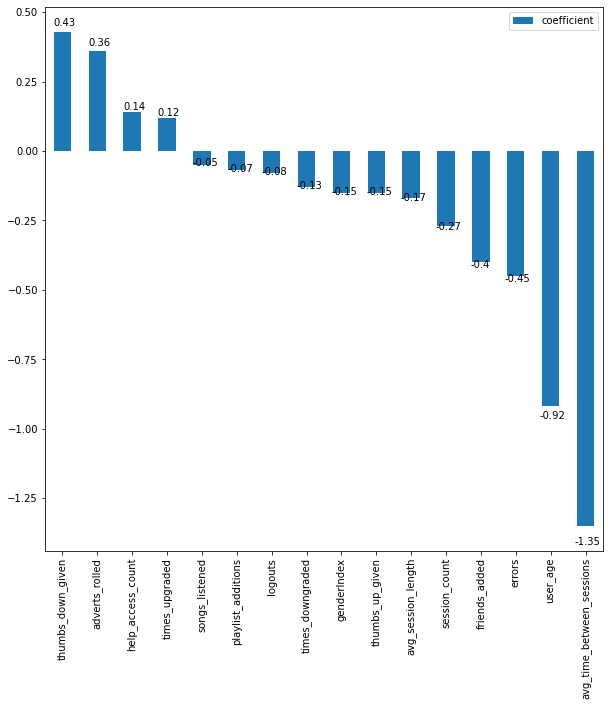

In [65]:
# Visualize
ax = coefficients_transposed.plot.bar(figsize=(10,10))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 0.995, p.get_height() * 1.05))

### Compute F1 Score

#### Model Evaluation Metrics
How well was churn predicted among churned users?

- **Precision** = True Positive / (True Positive + False Positive)
- **Recall** = True Positive / Total Actual Positive 
- **F1 Score** = 2 * ((Precision * Recall) / (Precision + Recall))

Source: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

In [66]:
# Calculate TP, FP, TN, FN
tp = results.filter((results.label == 1) & (results.prediction == 1)).count()
fp = results.filter((results.label == 0) & (results.prediction == 1)).count()
tn = results.filter((results.label == 0) & (results.prediction == 0)).count()
fn = results.filter((results.label == 1) & (results.prediction == 0)).count()
overall_users = results.count()

In [67]:
print("Overall users in test: " + str(overall_users))
print("True Positives: " + str(tp))
print("False Positives: " + str(fp))
print("True Negatives: " + str(tn))
print("False Negatives: " + str(fn))

Overall users in test: 60
True Positives: 5
False Positives: 5
True Negatives: 39
False Negatives: 11


In [68]:
precision = tp / (tp+fp)
recall = tp / (tp + fn)
f1_score = 2 * ((precision * recall) / (precision + recall))

print("Precision " + model_name + ": " + str(round(precision, 2)))
print("Recall " + model_name + ": " + str(round(recall, 2)))
print("F1 Score " + model_name + ": " + str(round(f1_score, 2)))

Precision Logistic Regression: 0.5
Recall Logistic Regression: 0.31
F1 Score Logistic Regression: 0.38


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [69]:
['female','user_age','paid_user',\
                                       'downgraded','total_session','interactions',\
                                      'thumbs_down','length','session_gap'],\
                            outputCol='NumFeatures',handleInvalid = 'skip')

SyntaxError: cannot assign to literal (<ipython-input-69-5bf4bc446928>, line 1)